In [9]:
# imports
import numpy as np
from math import comb, exp
from functools import lru_cache
import time
try:
    from tqdm import tqdm
    use_tqdm = True
except:
    use_tqdm = False
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib import cm
import os

In [4]:
"""
ntg_part1.py
Part 1 for reproducing:
  - payoff functions π_I, π_T, π_U
  - hypergeometric group sampling probability
  - expected payoffs f_I, f_T, f_U (finite X)
  - mutation-selection imitation probability T_{A->B} (eq. 2.1)

Formulas taken from the manuscript (payoffs, hypergeometric probability, eq.2.1).
Cite: Liu et al., rsif-2024-0726.R1_Proof_hi.pdf (uploaded).
"""


# -------------------------
# Utility: safe comb and hypergeometric probability
# -------------------------
@lru_cache(maxsize=None)
def nCr(n, r):
    if r < 0 or r > n:
        return 0
    return comb(n, r)

def hypergeom_prob(X_minus1, count_I_pool, count_T_pool, draws_N_minus1, NI, NT):
    """
    P(X-1, iI-1, iT, N-1, NI, NT) from the paper
    where:
      - X_minus1 = X - 1
      - count_I_pool = iI - 1  (for focal investor) OR iI (for other payoff calc)
      - count_T_pool = iT      (depending on focal)
      - draws_N_minus1 = N - 1
      - NI, NT are counts drawn from those pools (nonnegative ints)
    formula:
      C(count_I_pool, NI) * C(count_T_pool, NT) * C(X - iI - iT, draws_N_minus1 - NI - NT)
      -------------------------------------------------------------------------------
                              C(X_minus1, draws_N_minus1)
    """
    numerator = nCr(count_I_pool, NI) * nCr(count_T_pool, NT) * nCr(
        X_minus1 - count_I_pool - count_T_pool, draws_N_minus1 - NI - NT
    )
    denom = nCr(X_minus1, draws_N_minus1)
    if denom == 0:
        return 0.0
    return numerator / denom

# -------------------------
# Model payoff functions πI, πT, πU
# (these match Eqns in the paper; OT(NT) and OU(NT) defined by alpha, M)
# -------------------------
def OT(NT, alpha, M):
    # reward factor function O_T(NT) from manuscript
    # OT(NT) = 1 - alpha  if NT + 1 < M
    #         = alpha      if NT + 1 >= M
    return (1 - alpha) if (NT + 1 < M) else alpha

def OU(NT, alpha, M):
    # punishment factor O_U(NT)
    # OU(NT) = -alpha     if NT < M
    #        = alpha - 1  if NT >= M
    return (-alpha) if (NT < M) else (alpha - 1)

def payoff_pi_I(NI, NT, NU, params):
    """
    pi_I:
      - if NI == N-1: payoff = -delta
      - else: payoff = (RT*NT/(N-1-NI) * tv) - tv - delta  [careful with indices]
    Note: the paper uses expression RT * NT / (NT+NU+1) * tv returned to each investor.
    But in the πI formula the factor shown maps to RT*NT/(N-1-NI) in the snippet; to match paper
    we implement according to the expression in the PDF:
       πI = -δ  if NI == N-1
       otherwise: (RT * NT / (N - 1 - NI)) * tv - tv - δ
    """
    RT = params['RT']; tv = params['tv']; delta = params['delta']; N = params['N']
    if NI == N - 1:
        return - delta
    denom = (N - 1 - NI)
    # Avoid division by zero (should be protected by NI != N-1)
    return (RT * NT / denom) * tv - tv - delta

def payoff_pi_T(NI, NT, NU, params):
    """
    πT:
      - if NI == 0: payoff = -delta (no investors to get returns)
      - else: RT * NI / (N - NI) * tv - delta + N*delta/(NT+1) * OT(NT)
    Implementation follows the formula snippet in the PDF.
    """
    RT = params['RT']; tv = params['tv']; delta = params['delta']; N = params['N']
    alpha = params.get('alpha', 0.0); M = params.get('M', 0)
    if NI == 0:
        return - delta
    denom = (N - NI)
    # N*delta/(NT + 1) * OT(NT)
    incentive_term = (N * delta) / (NT + 1) * OT(NT, alpha, M)
    return (RT * NI / denom) * tv - delta + incentive_term

def payoff_pi_U(NI, NT, NU, params):
    """
    πU:
      - if NI == 0: payoff = -delta
      - else: RU * NI / (N - NI) * tv - delta + N*delta/(NU+1) * OU(NT)
    Note: OU depends on NT (the number of trustworthy trustees).
    """
    RU = params['RU']; tv = params['tv']; delta = params['delta']; N = params['N']
    alpha = params.get('alpha', 0.0); M = params.get('M', 0)
    if NI == 0:
        return - delta
    denom = (N - NI)
    incentive_term = (N * delta) / (NU + 1) * OU(NT, alpha, M)
    return (RU * NI / denom) * tv - delta + incentive_term

# -------------------------
# Expected payoffs fI, fT, fU (sum over NI, NT using hypergeometric)
# fI uses P(X-1, iI-1, iT, N-1, NI, NT)
# fT uses P(X-1, iI, iT-1, N-1, NI, NT)
# fU uses P(X-1, iI, iT, N-1, NI, NT)
# -------------------------
def expected_payoffs(iI, iT, X, params):
    """
    Compute (fI, fT, fU) for population state counts (iI, iT, iU = X - iI - iT)
    Returns tuple of floats (fI, fT, fU).
    """
    N = params['N']
    iU = X - iI - iT
    Xm1 = X - 1
    draws = N - 1

    fI = 0.0
    fT = 0.0
    fU = 0.0

    # NI runs 0..N-1, NT runs 0..N-1-NI
    for NI in range(0, draws + 1):
        for NT in range(0, draws - NI + 1):
            NU = draws - NI - NT
            # probabilities depend on focal type (counts in pool differ)
            p_I = hypergeom_prob(Xm1, iI - 1, iT, draws, NI, NT)  # for focal investor
            p_T = hypergeom_prob(Xm1, iI, iT - 1, draws, NI, NT)  # for focal trustworthy trustee
            p_U = hypergeom_prob(Xm1, iI, iT, draws, NI, NT)      # for focal untrustworthy trustee

            # compute payoffs for that group composition
            pi_I = payoff_pi_I(NI, NT, NU, params)
            pi_T = payoff_pi_T(NI, NT, NU, params)
            pi_U = payoff_pi_U(NI, NT, NU, params)

            fI += p_I * pi_I
            fT += p_T * pi_T
            fU += p_U * pi_U

    return fI, fT, fU

# -------------------------
# Mutation-selection imitation probability T_{A -> B} (eq. 2.1 in paper)
# TA->B = (1 - mu) * [ iA/X * iB/(X-1) * 1/(1+exp(-omega*(fB - fA))) ] + mu * iA/(2X)
# Note: paper's exact arrangement of factors uses iA/X and iB/(X-1) prefactors (we follow that)
# -------------------------
def T_A_to_B(iA, iB, X, fA, fB, mu, omega):
    """
    Compute probability that a participant who chooses A adopts B.
    """
    # avoid division by zero
    if X <= 1:
        return 0.0
    imitation = 0.0
    if X - 1 > 0:
        imitation = (iA / X) * (iB / (X - 1)) * (1.0 / (1.0 + np.exp(-omega * (fB - fA))))
    result = (1.0 - mu) * imitation + mu * (iA / (2.0 * X))
    return float(result)

# -------------------------
# Quick demonstration using default parameters from the paper figures:
# X=100, N=6, RU=6, RT=4, tv=1, mu=0.01, omega=10, delta variable, alpha, M
# -------------------------
if __name__ == "__main__":
    # default params (example)
    params = {
        'RT': 4.0,
        'RU': 6.0,
        'N' : 6,
        'tv': 1.0,
        'delta': 0.25,   # example
        'alpha': 0.0,    # pure reward example
        'M': 3          # threshold example
    }
    X = 60 # note: this param dictates the resolution of the computation, the higher the longer to run (default 100)
    # example population state: iI=2 investors, iT=10 trustworthy, remainder untrustworthy
    iI_example = 2
    iT_example = 10

    fI, fT, fU = expected_payoffs(iI_example, iT_example, X, params)
    print("Expected payoffs (fI, fT, fU) at state (iI={}, iT={}):".format(iI_example, iT_example))
    print(fI, fT, fU)

    # Example of computing T_{I->T} where we pick fI,fT and counts:
    mu = 0.01; omega = 10.0
    iA = iI_example
    iB = iT_example
    t_I_to_T = T_A_to_B(iA, iB, X, fI, fT, mu, omega)
    print("T_{I->T} =", t_I_to_T)


Expected payoffs (fI, fT, fU) at state (iI=2, iT=10):
-0.5603448275862069 0.05787278487915237 -0.044955083367522984
T_{I->T} = 0.005748355642325901


In [5]:
# ntg_part2_compute.py
# Part 2: build transition matrix P, compute stationary distribution (power iteration),
# compute mean frequencies and gradient-of-selection, save outputs to results_part2.npz.
#
# Requires: numpy, optionally tqdm for progress bar (pip install tqdm).
# If you already have Part 1 as a module, you can import expected_payoffs, T_A_to_B, etc.
# This file includes the functions from Part 1 for self-containment.

# --------- (re-used small helpers from Part 1, made self-contained) ---------
@lru_cache(maxsize=None)
def nCr(n, r):
    if r < 0 or r > n:
        return 0
    return comb(n, r)

def hypergeom_prob(X_minus1, count_I_pool, count_T_pool, draws_N_minus1, NI, NT):
    numerator = nCr(count_I_pool, NI) * nCr(count_T_pool, NT) * nCr(
        X_minus1 - count_I_pool - count_T_pool, draws_N_minus1 - NI - NT
    )
    denom = nCr(X_minus1, draws_N_minus1)
    if denom == 0:
        return 0.0
    return numerator / denom

def OT(NT, alpha, M):
    return (1 - alpha) if (NT + 1 < M) else alpha

def OU(NT, alpha, M):
    return (-alpha) if (NT < M) else (alpha - 1)

def payoff_pi_I(NI, NT, NU, params):
    RT = params['RT']; tv = params['tv']; delta = params['delta']; N = params['N']
    if NI == N - 1:
        return - delta
    denom = (N - 1 - NI)
    return (RT * NT / denom) * tv - tv - delta

def payoff_pi_T(NI, NT, NU, params):
    RT = params['RT']; tv = params['tv']; delta = params['delta']; N = params['N']
    alpha = params.get('alpha', 0.0); M = params.get('M', 0)
    if NI == 0:
        return - delta
    denom = (N - NI)
    incentive_term = (N * delta) / (NT + 1) * OT(NT, alpha, M)
    return (RT * NI / denom) * tv - delta + incentive_term

def payoff_pi_U(NI, NT, NU, params):
    RU = params['RU']; tv = params['tv']; delta = params['delta']; N = params['N']
    alpha = params.get('alpha', 0.0); M = params.get('M', 0)
    if NI == 0:
        return - delta
    denom = (N - NI)
    incentive_term = (N * delta) / (NU + 1) * OU(NT, alpha, M)
    return (RU * NI / denom) * tv - delta + incentive_term

# expected_payoffs with caching
_expected_cache = {}
def expected_payoffs(iI, iT, X, params):
    key = (iI, iT, X, params['N'], params['RT'], params['RU'], params['tv'], params['delta'], params.get('alpha',0.0), params.get('M',0))
    if key in _expected_cache:
        return _expected_cache[key]
    N = params['N']
    iU = X - iI - iT
    Xm1 = X - 1
    draws = N - 1

    fI = 0.0
    fT = 0.0
    fU = 0.0

    for NI in range(0, draws + 1):
        for NT in range(0, draws - NI + 1):
            NU = draws - NI - NT
            # probabilities depend on focal type (counts in pool differ)
            p_I = hypergeom_prob(Xm1, iI - 1, iT, draws, NI, NT)  # investor focal
            p_T = hypergeom_prob(Xm1, iI, iT - 1, draws, NI, NT)  # trustworthy focal
            p_U = hypergeom_prob(Xm1, iI, iT, draws, NI, NT)      # untrustworthy focal

            pi_I = payoff_pi_I(NI, NT, NU, params)
            pi_T = payoff_pi_T(NI, NT, NU, params)
            pi_U = payoff_pi_U(NI, NT, NU, params)

            fI += p_I * pi_I
            fT += p_T * pi_T
            fU += p_U * pi_U

    _expected_cache[key] = (fI, fT, fU)
    return fI, fT, fU

def T_A_to_B(iA, iB, X, fA, fB, mu, omega):
    if X <= 1:
        return 0.0
    imitation = 0.0
    if X - 1 > 0:
        imitation = (iA / X) * (iB / (X - 1)) * (1.0 / (1.0 + np.exp(-omega * (fB - fA))))
    result = (1.0 - mu) * imitation + mu * (iA / (2.0 * X))
    return float(result)

# -------------------------
# Build state list and index mapping
# states are (iI, iT) with iI >=0, iT >=0 and iI + iT <= X
# total_states = (X+1)(X+2)/2
# -------------------------
def enumerate_states(X):
    states = []
    for iI in range(0, X+1):
        for iT in range(0, X+1 - iI):
            states.append((iI, iT))
    index_of = {s: idx for idx, s in enumerate(states)}
    return states, index_of

# -------------------------
# Build transition matrix P (dense). For each state (iI,iT), compute outgoing probabilities:
# TU->I (iI+1, iT), TI->U (iI-1, iT), TU->T (iI, iT+1), TT->U (iI, iT-1),
# TI->T (iI-1, iT+1), TT->I (iI+1, iT-1)
# (only if resulting indices valid). Self-loop = 1 - sum(outgoing)
# -------------------------
def build_transition_matrix(X, params, mu, omega, show_progress=True):
    states, index_of = enumerate_states(X)
    S = len(states)
    P = np.zeros((S, S), dtype=np.float64)

    # We'll cache expected payoffs for each state
    if use_tqdm and show_progress:
        iterator = tqdm(states, desc="Building P")
    else:
        iterator = states

    for s in iterator:
        iI, iT = s
        idx = index_of[s]
        iU = X - iI - iT

        # compute expected payoffs once per state
        fI, fT, fU = expected_payoffs(iI, iT, X, params)

        # compute all TA->B probabilities (use counts for A and B in current state)
        # note: make sure iA and iB correspond to counts in the current state
        # (for I->T: focal is I, role model is T)
        T_I_to_T = T_A_to_B(iI, iT, X, fI, fT, mu, omega)
        T_I_to_U = T_A_to_B(iI, iU, X, fI, fU, mu, omega)

        T_T_to_I = T_A_to_B(iT, iI, X, fT, fI, mu, omega)
        T_T_to_U = T_A_to_B(iT, iU, X, fT, fU, mu, omega)

        T_U_to_I = T_A_to_B(iU, iI, X, fU, fI, mu, omega)
        T_U_to_T = T_A_to_B(iU, iT, X, fU, fT, mu, omega)

        # now map these to adjacent state transitions (check validity)
        total_out = 0.0

        # TU -> I : U becomes I -> (iI+1, iT)
        if iU >= 1 and iI + 1 <= X:
            s2 = (iI + 1, iT)
            P[idx, index_of[s2]] += T_U_to_I
            total_out += T_U_to_I

        # TI -> U : I becomes U -> (iI-1, iT)  (I->U)
        if iI >= 1 and iI - 1 >= 0:
            s2 = (iI - 1, iT)
            P[idx, index_of[s2]] += T_I_to_U
            total_out += T_I_to_U

        # TU -> T : U becomes T -> (iI, iT+1)
        if iU >= 1 and iT + 1 <= X:
            s2 = (iI, iT + 1)
            P[idx, index_of[s2]] += T_U_to_T
            total_out += T_U_to_T

        # TT -> U : T becomes U -> (iI, iT-1)
        if iT >= 1 and iT - 1 >= 0:
            s2 = (iI, iT - 1)
            P[idx, index_of[s2]] += T_T_to_U
            total_out += T_T_to_U

        # TI -> T : I becomes T -> (iI -1, iT +1)
        if iI >= 1 and (iI - 1) + (iT + 1) <= X:
            s2 = (iI - 1, iT + 1)
            P[idx, index_of[s2]] += T_I_to_T
            total_out += T_I_to_T

        # TT -> I : T becomes I -> (iI +1, iT -1)
        if iT >= 1 and (iI + 1) + (iT - 1) <= X:
            s2 = (iI + 1, iT - 1)
            P[idx, index_of[s2]] += T_T_to_I
            total_out += T_T_to_I

        # self-loop probability
        stay = 1.0 - total_out
        # numerical guard
        if stay < 0:
            # tiny negative due to rounding; clamp
            if stay > -1e-12:
                stay = 0.0
            else:
                # if more negative then warn and renormalize
                # renormalize outgoing by scaling
                if total_out > 0:
                    scale = 1.0 / total_out
                    for j in range(S):
                        if P[idx, j] > 0:
                            P[idx, j] *= scale
                    stay = 0.0
                else:
                    stay = 1.0
        P[idx, idx] += stay

    return P, states, index_of

# -------------------------
# Power iteration to find stationary distribution
# -------------------------
def find_stationary_dist_power(P, tol=1e-12, max_iter=20000, verbose=False):
    S = P.shape[0]
    # start uniform
    x = np.ones(S, dtype=np.float64) / S
    for it in range(max_iter):
        x_next = x @ P  # row-vector style
        diff = np.linalg.norm(x_next - x, 1)
        x = x_next
        if verbose and (it % 200 == 0):
            print(f"iter {it}, L1 diff = {diff:.3e}")
        if diff < tol:
            if verbose:
                print(f"converged in {it} iterations, diff={diff:.2e}")
            break
    # normalize
    x = x / x.sum()
    return x

# -------------------------
# Compute mean frequencies and gradient-of-selection
# gradient components:
#   Delta_T(state) = P(state -> state with iT+1) - P(state -> state with iT-1)
#   Delta_I(state) = P(state -> state with iI+1) - P(state -> state with iI-1)
# We'll compute these using P entries we constructed.
# -------------------------
def compute_summary_and_gradients(P, states, index_of, X):
    S = len(states)
    # stationary dist computed earlier and passed; but here we only compute gradients and mean freqs given stationary
    # function will compute mean frequencies and gradients given P and states after we compute stationary dist.
    # We'll return arrays: mean_rho (I,T,U), gradient_I, gradient_T
    return None

# -------------------------
# Main runner: build P, compute stationary dist, compute means and gradient arrays, save to file
# -------------------------
def main_compute_and_save(X=100, params=None, mu=0.01, omega=10.0, out_filename="results_part2.npz"):
    if params is None:
        params = {'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':0.25, 'alpha':0.0, 'M':3}
    t0 = time.time()
    P, states, index_of = build_transition_matrix(X, params, mu, omega, show_progress=True)
    t1 = time.time()
    print(f"P built: shape={P.shape}  (took {t1-t0:.1f}s)")

    # stationary dist via power iteration
    x = find_stationary_dist_power(P, tol=1e-12, max_iter=20000, verbose=True)
    t2 = time.time()
    print(f"Stationary dist computed (took {t2-t1:.1f}s); sum(x)={x.sum():.12f}")

    # compute mean frequencies
    # For each state s=(iI,iT), frequency of I is iI/X, T is iT/X, U is (X-iI-iT)/X
    freq_I = np.array([s[0]/X for s in states])
    freq_T = np.array([s[1]/X for s in states])
    freq_U = 1.0 - freq_I - freq_T

    mean_rho_I = np.dot(x, freq_I)
    mean_rho_T = np.dot(x, freq_T)
    mean_rho_U = np.dot(x, freq_U)
    print(f"Mean frequencies: <rho_I>={mean_rho_I:.6f}, <rho_T>={mean_rho_T:.6f}, <rho_U>={mean_rho_U:.6f}")

    # compute gradients: Delta_T = P(iT+1) - P(iT-1); Delta_I similarly
    S = len(states)
    grad_I = np.zeros(S, dtype=np.float64)
    grad_T = np.zeros(S, dtype=np.float64)
    for idx, s in enumerate(states):
        iI, iT = s
        # +I: transition to state with iI+1 (either (iI+1,iT) or (iI+1,iT-1) depending)
        p_plus_I = 0.0
        p_minus_I = 0.0
        p_plus_T = 0.0
        p_minus_T = 0.0

        # any outgoing to a state whose iI is iI+1 contributes to +I
        target_plus_I_candidates = []
        if iI + 1 <= X:
            # (iI+1, iT) and (iI+1, iT-1) are possible adjacent states
            if (iI + 1, iT) in index_of:
                target_plus_I_candidates.append((iI + 1, iT))
            if (iI + 1, iT - 1) in index_of:
                target_plus_I_candidates.append((iI + 1, iT - 1))
        for s2 in target_plus_I_candidates:
            p_plus_I += P[idx, index_of[s2]]

        # minus I: any outgoing to state whose iI is iI-1
        if iI - 1 >= 0:
            if (iI - 1, iT) in index_of:
                p_minus_I += P[idx, index_of[(iI - 1, iT)]]
            if (iI - 1, iT + 1) in index_of:
                p_minus_I += P[idx, index_of[(iI - 1, iT + 1)]]

        # plus T: any outgoing to state with iT+1
        if iT + 1 <= X:
            if (iI, iT + 1) in index_of:
                p_plus_T += P[idx, index_of[(iI, iT + 1)]]
            if (iI - 1, iT + 1) in index_of:
                p_plus_T += P[idx, index_of[(iI - 1, iT + 1)]]

        # minus T: outgoing to iT-1
        if iT - 1 >= 0:
            if (iI, iT - 1) in index_of:
                p_minus_T += P[idx, index_of[(iI, iT - 1)]]
            if (iI + 1, iT - 1) in index_of:
                p_minus_T += P[idx, index_of[(iI + 1, iT - 1)]]

        grad_I[idx] = p_plus_I - p_minus_I
        grad_T[idx] = p_plus_T - p_minus_T

    # Save to disk
    np.savez_compressed(out_filename,
                        P=P, states=np.array(states, dtype=np.int32),
                        index_keys=np.array(list(index_of.keys()), dtype=np.int32),
                        index_vals=np.array(list(index_of.values()), dtype=np.int32),
                        stationary=x,
                        freq_I=freq_I, freq_T=freq_T, freq_U=freq_U,
                        mean_rho_I=mean_rho_I, mean_rho_T=mean_rho_T, mean_rho_U=mean_rho_U,
                        grad_I=grad_I, grad_T=grad_T,
                        params=params, X=X, mu=mu, omega=omega)
    t3 = time.time()
    print(f"Saved results to {out_filename} (took {t3-t2:.1f}s). Total time {t3-t0:.1f}s")
    return out_filename

# If run as script, run with default parameters
if __name__ == "__main__":
    # Example: use X=100 (this creates ~5151 states)
    # NOTE: for large X this can take some time & memory; adjust X as needed.
    out = main_compute_and_save(X=100,
                                params={'RT':4.0, 'RU':6.0, 'N':6, 'tv':1.0, 'delta':0.25, 'alpha':0.0, 'M':3},
                                mu=0.01, omega=10.0,
                                out_filename="results_part2.npz")
    print("Done. Output file:", out)


Building P: 100%|██████████| 5151/5151 [00:00<00:00, 12896.14it/s]


P built: shape=(5151, 5151)  (took 0.4s)
iter 0, L1 diff = 9.154e-03
iter 200, L1 diff = 4.940e-03
iter 400, L1 diff = 2.509e-03
iter 600, L1 diff = 1.164e-03
iter 800, L1 diff = 4.955e-04
iter 1000, L1 diff = 2.383e-04
iter 1200, L1 diff = 1.388e-04
iter 1400, L1 diff = 9.488e-05
iter 1600, L1 diff = 7.187e-05
iter 1800, L1 diff = 5.789e-05
iter 2000, L1 diff = 4.827e-05
iter 2200, L1 diff = 4.101e-05
iter 2400, L1 diff = 3.520e-05
iter 2600, L1 diff = 3.037e-05
iter 2800, L1 diff = 2.628e-05
iter 3000, L1 diff = 2.277e-05
iter 3200, L1 diff = 1.975e-05
iter 3400, L1 diff = 1.713e-05
iter 3600, L1 diff = 1.486e-05
iter 3800, L1 diff = 1.289e-05
iter 4000, L1 diff = 1.118e-05
iter 4200, L1 diff = 9.698e-06
iter 4400, L1 diff = 8.410e-06
iter 4600, L1 diff = 7.292e-06
iter 4800, L1 diff = 6.322e-06
iter 5000, L1 diff = 5.480e-06
iter 5200, L1 diff = 4.750e-06
iter 5400, L1 diff = 4.117e-06
iter 5600, L1 diff = 3.568e-06
iter 5800, L1 diff = 3.092e-06
iter 6000, L1 diff = 2.680e-06
iter 

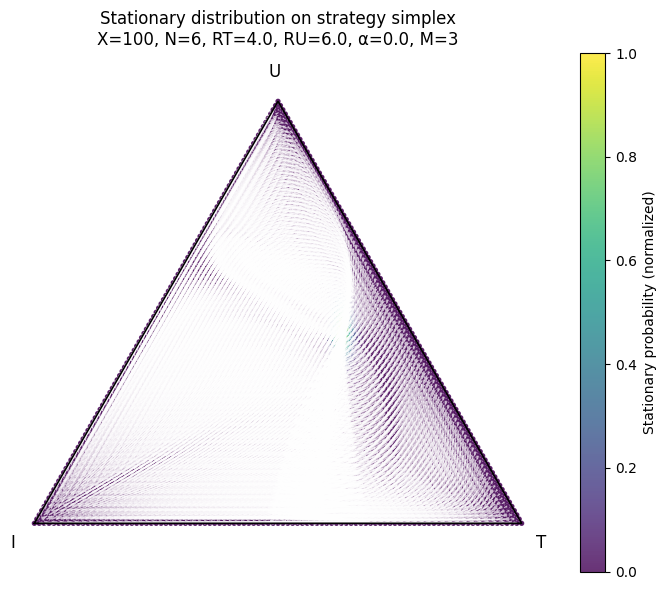

In [8]:
# this template can be used for figure 1 to 3
# ntg_part3_viz_simplex.py
# Visualization: triangular simplex heatmap + vector field arrows
# Load results_part2.npz from Part 2

# Load results
data = np.load("results_part2.npz", allow_pickle=True)
states = data["states"]
x_stat = data["stationary"]
grad_I = data["grad_I"]
grad_T = data["grad_T"]
freq_I = data["freq_I"]
freq_T = data["freq_T"]
freq_U = data["freq_U"]
X = int(data["X"])
params = data["params"].item()

# ---- Map simplex (ρ_I, ρ_T, ρ_U) → 2D coordinates for plotting ----
# standard 2-simplex mapping (ρ_I, ρ_T, ρ_U) → (x,y)
# vertices: I=(0,0), T=(1,0), U=(0.5, sqrt(3)/2)
def simplex_to_xy(rI, rT, rU):
    x = rT + 0.5 * rU
    y = (np.sqrt(3)/2) * rU
    return x, y

x_coords, y_coords = simplex_to_xy(freq_I, freq_T, freq_U)

# normalize stationary distribution for color intensity
p_norm = x_stat / x_stat.max()

# ---- Plot heatmap using scatter ----
plt.figure(figsize=(7,6))
sc = plt.scatter(x_coords, y_coords, c=p_norm, cmap="viridis", s=8, alpha=0.8)
plt.colorbar(sc, label="Stationary probability (normalized)")
plt.title("Stationary distribution on strategy simplex\n"
          f"X={X}, N={params['N']}, RT={params['RT']}, RU={params['RU']}, α={params['alpha']}, M={params['M']}")
plt.axis("equal")
plt.axis("off")

# ---- Overlay gradient vectors (Δ_I, Δ_T projected to (x,y)) ----
# convert (Δ_I, Δ_T) to Δρ_U = -Δ_I - Δ_T (since sum=1)
# then project to (dx,dy)
dU = -grad_I - grad_T
dx, dy = simplex_to_xy(grad_I, grad_T, dU)
# normalize vectors for clarity
scale = 0.15 / np.max(np.sqrt(dx**2 + dy**2))
plt.quiver(x_coords, y_coords, dx*scale, dy*scale,
           angles="xy", scale_units="xy", scale=1, color="white", width=0.003, alpha=0.7)

# draw triangle border
verts = np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2],[0,0]])
plt.plot(verts[:,0], verts[:,1], 'k-', lw=1.2)
plt.text(-0.05,-0.05,"I",fontsize=12)
plt.text(1.03,-0.05,"T",fontsize=12)
plt.text(0.48,np.sqrt(3)/2+0.05,"U",fontsize=12)

plt.tight_layout()
plt.show()


missing results_delta0.10.npz
missing results_delta0.20.npz
missing results_delta0.25.npz
missing results_delta0.30.npz
missing results_delta0.40.npz


ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

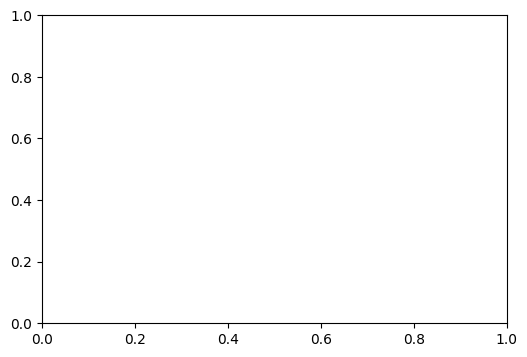

In [11]:
# template for the rest of the graphs
# Sweep delta and plot mean frequencies (bar or line)

# Suppose you saved multiple result files: results_delta0.1.npz, results_delta0.2.npz, ...
deltas = [0.1, 0.2, 0.25, 0.3, 0.4]
rhoI_list, rhoT_list, rhoU_list = [], [], []

for d in deltas:
    fname = f"results_delta{d:.2f}.npz"
    if not os.path.exists(fname):
        print("missing", fname)
        continue
    data = np.load(fname, allow_pickle=True)
    rhoI_list.append(float(data["mean_rho_I"]))
    rhoT_list.append(float(data["mean_rho_T"]))
    rhoU_list.append(float(data["mean_rho_U"]))

plt.figure(figsize=(6,4))
plt.plot(deltas, rhoI_list, 'o-', label='Investor')
plt.plot(deltas, rhoT_list, 's-', label='Trustworthy')
plt.plot(deltas, rhoU_list, '^-', label='Untrustworthy')
plt.xlabel("δ (incentive value)")
plt.ylabel("Mean frequency ⟨ρ⟩")
plt.title("Mean strategy frequencies vs δ")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


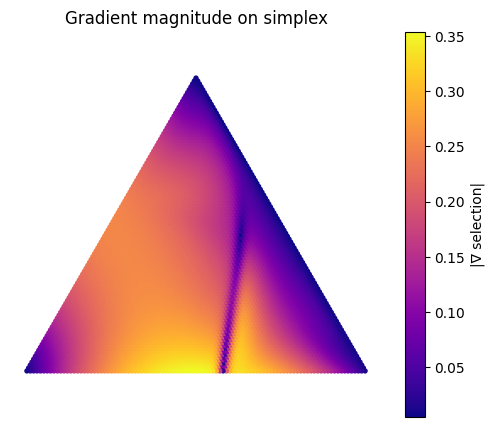

In [12]:
# extra
grad_mag = np.sqrt(grad_I**2 + grad_T**2)
plt.figure(figsize=(6,5))
plt.scatter(x_coords, y_coords, c=grad_mag, cmap="plasma", s=8)
plt.colorbar(label="|∇ selection|")
plt.axis("equal"); plt.axis("off")
plt.title("Gradient magnitude on simplex")
plt.show()
